# Di-Higgs regressor final training

## Import

### Import modules

In [61]:
import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras import backend as K
from __future__ import division ,print_function
import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import seaborn as sns
import sys
sys.path.append('../../../../modules')
from MPPlot import *
from Processors import *
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
sys.path.append('../')
from Regression_Application import *


### Import data
Here just looking at mu tau_h b b final-state

In [62]:
mode = "mu_tau_b_b"
loc = './../../../../../data_n/'
SignalData = []
BackgroundData = []

energies = [260,270,280,300,320,400,500,550,600,700]
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))



 #Load data from CSV files
for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['gen_label'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(loc + back + "_TuneCUETP8M1_13TeV.csv")
    backgroundData['gen_label'] = back
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset
def abs_(x):
    if type(x) is float:
        return abs(x)
    else:
        return x

def cleanData(X):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    X.applymap(abs_)
    
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X

data = cleanData(data)

Samples contains 10417 signal events and 168053 background events
178470 events in total


## Configure data

### Create development and validation samples

In [63]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum
 

moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

In [64]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)

    
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))


3928 events for training, 174533 events for validation


### Apply regressors

In [65]:
bRegressor = BPairRegressor(data, "../bRegression/weights/NN_B_Regressor_App_" + mode + "_" , mode)
bRegressor.evalResponse()
bRegressor.getExtraVariables()
bRegressor.refineDiHiggsVector()

10 components found in ensemble


In [66]:
tauRegressor = TauPairRegressor(data, "../tauRegression/weights/NN_Tau_Regressor_App_" + mode + "_" , mode)
tauRegressor.evalResponse()
tauRegressor.getExtraVariables()
tauRegressor.refineDiHiggsVector()

10 components found in ensemble


In [67]:
hhMomRegressor = HHMomRegressor(data, "../hhMomRegression/weights/NN_HH_Mom_Regressor_App_" + mode + "_" , mode)
hhMomRegressor.evalResponse()
hhMomRegressor.getExtraVariables()

10 components found in ensemble


../Regression_Application.py:118: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  self.data[prefix + '|p|'] = np.sqrt(np.square(self.data.ix[:, prefix + 'px'])+np.square(self.data.ix[:, prefix + 'py'])+np.square(self.data.ix[:, prefix + 'pz']))
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.o

### Specify variables

In [68]:
data.rename(columns={'weight': 'gen_weight'}, inplace=True)
genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi'] if x in var]
other = [var for var in trainFeatures for x in [ 'csv', 'Fit'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi + other]

In [69]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT','mT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
regFeatures = [var for var in trainFeatures if (str.startswith(var, "reg"))]
regBFeatures = [var for var in trainFeatures if (str.startswith(var, "regB_"))]
regTauFeatures = [var for var in trainFeatures if (str.startswith(var, "regTau_"))]
regHHMomFeatures = [var for var in trainFeatures if (str.startswith(var, "regHH_"))]
regBDiHiggs = [var for var in regBFeatures if (str.startswith(var, "regB_diH_"))]
regTauDiHiggs = [var for var in regTauFeatures if (str.startswith(var, "regTau_diH_"))]
diHiggsFeatures = [var for var in trainFeatures if (str.startswith(var, "diH_"))]
regBasis = [var[var.find("_")+1:] for var in regFeatures]
massFeatures = [var for var in trainFeatures if "_mass" in var]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in  shapeFeatures + pTEtaPhi + hlFeatures + recoFeatures]
reducedFSFeatures = [var for var in fsFeatures if var not in regBasis]
reducedRecoFeatures = [var for var in recoFeatures if var not in regBasis]


In [70]:
set0 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi + regBFeatures + regTauFeatures + regHHMomFeatures] + ['hl_mT']
set1 = [var for var in reducedFSFeatures + reducedRecoFeatures if var not in pTEtaPhi + regBDiHiggs + regHHMomFeatures] + ['hl_mT']
set2 = [var for var in reducedFSFeatures + reducedRecoFeatures if var not in pTEtaPhi + regBDiHiggs + regTauDiHiggs + shapeFeatures] + ['hl_mT'] + ['regTau_diH_mass']

## Specify options

In [71]:
regTrainFeatures = set2
regModel = 'model0'
normIn = True
normOut = True
pca = True
whiten = False
nSplits = 10
cvTests = True
ensembleSize = 10
ensembleMode = 'loss'
regTargetFeatures = ['gen_diH_mass']
print ("\nTraining on", len(regTrainFeatures), "features:", [var for var in regTrainFeatures])
print ("\nRegressing to", len(regTargetFeatures), "features:", [var for var in regTargetFeatures])


Training on 52 features: ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_1_mass', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_0_|p|', 'regB_b_0_E', 'regB_b_1_|p|', 'regB_b_1_E', 'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regB_h_bb_E', 'regB_h_bb_|p|', 'regB_h_bb_mass', 'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_0_|p|', 'regTau_t_0_E', 'regTau_t_1_|p|', 'regTau_t_1_E', 'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regTau_h_tt_E', 'regTau_h_tt_|p|', 'regTau_h_tt_mass', 'regHH_diH_px', 'regHH_diH_py', 'regHH_diH_pz', 'regHH_diH_|p|', 'regHH_diH_E', 'hl_mT', 'regTau_diH_mass']

Regressing to 1 features: ['gen_diH_mass']


In [72]:
devData = data.loc[sig_devIndeces].copy()
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)
print ("{0} events for training, {1} events for validation".format(len(devData), len(valData)))

3928 events for training, 174533 events for validation


## Define regressor

In [73]:
def getLayout(params):
    architecture = int(params[0])
    nodes = int(params[1])
    depth = int(params[2])
    layout = np.zeros(depth).astype(int)
    if architecture == 0: #Box: same number of nodes in each layer
        layout.fill(nodes)
    if architecture == 1: #Taper: linear reduction of width with depth
        coef = (len(regTargetFeatures)-nodes)/(depth+1)
        for l in range(depth):
            layout[l] = nodes+(coef*l)
    if architecture == 2: #Choke: linear reduction down to Noutputs at centre layer
        centre = int(math.ceil(depth/2))
        coefRed = (len(regTargetFeatures)-nodes)/(centre)
        coefInc = (nodes-len(regTargetFeatures))/(depth-centre)
        mod = -1
        if (depth % 2 == 0) and (depth != 2):
            mod = 1
        for l in range(centre+mod):
            layout[l] = nodes+(coefRed*l)
        for l in range(centre+mod, depth):
            layout[l] = len(regTargetFeatures)+(coefInc*(l-centre+1))
    if architecture == 3: #Funnel: linearly reduces to Noutputs at centre layer then moves to box layput
        centre = int(math.ceil(depth/2))
        coefRed = (len(regTargetFeatures)-nodes)/(centre)
        mod = -1
        if (depth % 2 == 0) and (depth != 2):
            mod = 1
        for l in range(centre+mod):
            layout[l] = nodes+(coefRed*l)
        for l in range(centre+mod, depth):
            layout[l] = len(regTargetFeatures)
    return layout

In [74]:
def getParameterisedRegressor(params):
    params = params.tolist()
    noise = params[0]
    dropout = params[1]
    layers = getLayout(params[2:])
    regModel = Sequential()
    regModel.add(Dense(int(layers[0]), input_dim=len(regTrainFeatures), init='glorot_normal'))
    regModel.add(PReLU())
    regModel.add(GaussianNoise(noise))
    regModel.add(BatchNormalization())
    regModel.add(Dropout(dropout))
    for i in layers[1:]:
        if i < len(regTargetFeatures): break
        regModel.add(Dense(int(i), init='glorot_normal'))
        regModel.add(PReLU())
        regModel.add(GaussianNoise(noise))
        regModel.add(BatchNormalization())
        regModel.add(Dropout(dropout))
    regModel.add(Dense(len(regTargetFeatures), activation='linear', init='glorot_normal'))
    regModel.compile(loss='mse', optimizer='nadam')
    modelVersion = "model0"
    return regModel

In [75]:
compileArgs = {'loss' : 'mse', 'optimizer' : 'nadam'}

def getRegressor(model):
    regModel = Sequential()
    if model == "model0":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal', activation='relu'))
        regModel.add(Dense(100, kernel_initializer='he_normal', activation='relu'))
        regModel.add(Dense(100, kernel_initializer='he_normal', activation='relu'))
        regModel.add(Dense(100, kernel_initializer='he_normal', activation='relu'))
        regModel.add(Dense(100, kernel_initializer='he_normal', activation='relu'))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model1":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model2":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model3":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(BatchNormalization())
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(BatchNormalization())
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(BatchNormalization())
        regModel.add(PReLU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model4":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_uniform'))
    elif model == "model5":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model6":
        regModel.add(Dense(150, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(120, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal')) 
    elif model == "model7":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='glorot_normal', activation='linear'))
        regModel.add(Dense(100, kernel_initializer='glorot_normal', activation='linear'))
        regModel.add(Dense(100, kernel_initializer='glorot_normal', activation='linear'))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model8":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model9":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model10":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    regModel.compile(**compileArgs)
    return regModel

## Evaluation

### Calculate pull

In [76]:
def getResponse(pred, act):
    pull = pred[:,0]-act
    return (pull.mean(), pull.std())

### Preprocess data

In [77]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
stepsOut = []
if normOut:
    stepsOut.append(('normOut', StandardScaler()))
else:
    stepsOut.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
outputPipe = Pipeline(stepsOut)

In [78]:
X_reg = inputPipe.fit_transform(devData[regTrainFeatures].values.astype(theano.config.floatX))
y_reg = outputPipe.fit_transform(devData[regTargetFeatures].values.astype(theano.config.floatX))

### Train regressors
Train nSplit times to find best convergence

In [79]:
trainingData = (None, None)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(trainingData[0], trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

In [80]:
trainParams = {'epochs' : 10000, 'batch_size' : 64, 'verbose' : 0}

In [81]:
start = time.time()
results = []
histories = []
os.system("rm train_weights/*.h5")
os.system("rm train_weights/*.json")
os.system("rm train_weights/*.pkl")
if cvTests:
    kf = KFold(n_splits=nSplits, shuffle=True)
    i = 0
    for train, test in kf.split(X_reg):
        i += 1
        print ("Running fold", i, "/", nSplits)
        model = None # Clearing the NN
        model = getRegressor(regModel)
        model.reset_states #Just checking
        trainingData = (X_reg[train], y_reg[train])
        lossHistory = LossHistory()
        earlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
        saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
        model.fit(X_reg[train], y_reg[train],
                  validation_data = (X_reg[test], y_reg[test]),
                  callbacks = [earlyStop, saveBest, lossHistory],
                  **trainParams)
        histories.append(lossHistory.losses)
        model.load_weights("train_weights/best.h5")
        results.append({})
        results[-1]['mean'], results[-1]['std'] = getResponse(outputPipe.inverse_transform(model.predict(X_reg[test], verbose=0)),
                                                              outputPipe.inverse_transform(y_reg[test]))
        results[-1]['loss'] = model.evaluate(X_reg[test], y_reg[test], verbose=0)
        print ("Score is:", results[-1])
        model.save('train_weights/train_' + str(i-1) + '.h5')
else :
    for i in range(nSplits):
        print ("Running fold", i+1, "/", nSplits)
        model = None # Clearing the NN.
        model = getRegressor(regModel)
        model.reset_states #Just checking
        earlyStop = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
        saveBest = ModelCheckpoint("train_weights/best.h5", monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
        histories.append(model.fit(X_reg, y_reg,
                  callbacks = [earlyStop, saveBest],
                  **trainParams))
        model.load_weights("train_weights/best.h5")
        results.append({})
        results[-1]['mean'], results[-1]['std'] = getResponse(outputPipe.inverse_transform(model.predict(X_reg, verbose=0)),
                                                              outputPipe.inverse_transform(y_reg))
        results[-1]['loss'] = model.evaluate(X_reg, y_reg, verbose=0)
        print ("Score is:", results[-1])
        model.save('train_weights/train_' + str(i) + '.h5')
with open('train_weights/resultsFile.pkl', 'w') as fout:
    pickle.dump(results, fout)
print ("Cross-validation took {:.3f}s ".format(time.time() - start))
X_reg = None
y_reg = None
train = None
test = None
model.summary()
model = None

Running fold 1 / 10
Epoch 00041: early stopping
Score is: {'std': 192.7036, 'loss': 0.052281850365964513, 'mean': -1.0508856}
Running fold 2 / 10
Epoch 00052: early stopping
Score is: {'std': 191.38937, 'loss': 0.04673122034026618, 'mean': -0.1665477}
Running fold 3 / 10
Epoch 00055: early stopping
Score is: {'std': 201.1248, 'loss': 0.054472765773913939, 'mean': 1.890447}
Running fold 4 / 10
Epoch 00062: early stopping
Score is: {'std': 195.34303, 'loss': 0.057192659787549317, 'mean': -0.61257035}
Running fold 5 / 10
Epoch 00032: early stopping
Score is: {'std': 204.70355, 'loss': 0.05278583106042168, 'mean': -0.025520256}
Running fold 6 / 10
Epoch 00061: early stopping
Score is: {'std': 199.45644, 'loss': 0.04811869392233116, 'mean': 2.2641292}
Running fold 7 / 10
Epoch 00039: early stopping
Score is: {'std': 186.81577, 'loss': 0.05537404091531084, 'mean': 0.1771505}
Running fold 8 / 10
Epoch 00068: early stopping
Score is: {'std': 195.48697, 'loss': 0.044503169470767635, 'mean': 1.7

### Plot training histories

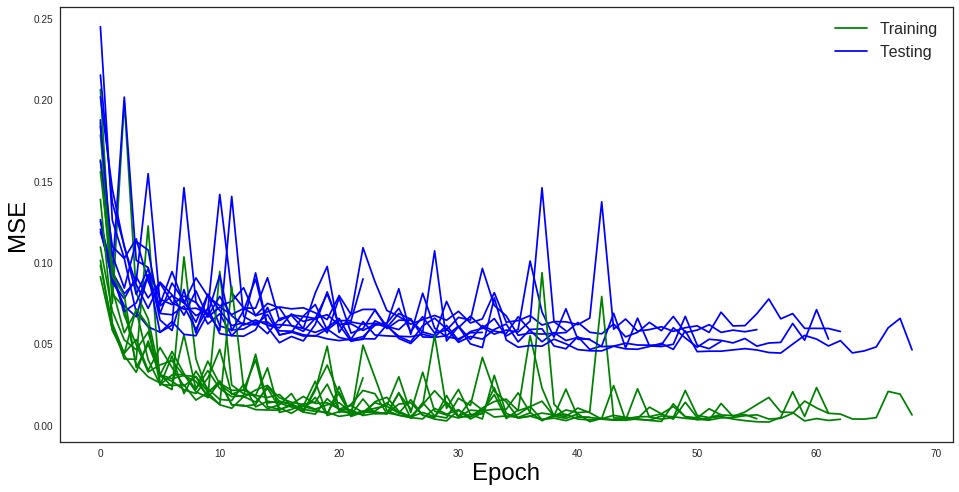

In [82]:
plt.figure(figsize=(16,8))
if cvTests:
    for i, history in enumerate(histories):
        if i == 0:
            plt.plot(history['loss'], color='g', label='Training')
            plt.plot(history['val_loss'], color='b', label='Testing')
        else:
            plt.plot(history['loss'], color='g')
            plt.plot(history['val_loss'], color='b')
    plt.legend(fontsize=16)
else:
    for history in histories:
        plt.plot(history.history['loss'])
plt.xlabel("Epoch", fontsize=24, color='black')
plt.ylabel("MSE", fontsize=24, color='black')

## Construct ensemble

In [83]:
results = None
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [84]:
def loadModel(cycle, location='train_weights/train_'):
    cycle = int(cycle)
    model = load_model(location + str(cycle) + '.h5')
    model.compile(**compileArgs)
    return model

In [85]:
def getWeights(value, met):
    return 1/value

In [86]:
ensemble = []
weights = []
print ("Choosing ensemble by", ensembleMode)
if ensembleMode == 'mix':
    for met in results[0]:
        print( "Choosing best for metric", met)
        cycle = np.argmin([result[met] for result in results])
        print (met, "Model", "is", cycle, "with", met, "=", results[cycle][met])
        ensemble.append(loadModel(cycle))
        weights.append(1)
else:
    dtype = [('cycle', int), ('result', float)]
    values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(results)], dtype=dtype),
                     order=['result'])
    for i in range(min([ensembleSize, len(results)])):
        ensemble.append(loadModel(values[i]['cycle']))
        weights.append(getWeights(values[i]['result'], ensembleMode))
        print ("Model", i, "is", values[i]['cycle'], "with", ensembleMode, "=", values[i]['result'])
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

Choosing ensemble by loss
Model 0 is 7 with loss = 0.0445031694708
Model 1 is 1 with loss = 0.0467312203403
Model 2 is 5 with loss = 0.0481186939223
Model 3 is 0 with loss = 0.052281850366
Model 4 is 4 with loss = 0.0527858310604
Model 5 is 2 with loss = 0.0544727657739
Model 6 is 8 with loss = 0.0551970180656
Model 7 is 6 with loss = 0.0553740409153
Model 8 is 3 with loss = 0.0571926597875
Model 9 is 9 with loss = 0.0599940700495


## Response of ensemble on development data

###  Preprocess data

In [87]:
X_dev = inputPipe.transform(devData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [88]:
pred = np.zeros((len(devData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_dev, verbose=0)) 
devData['regHH_diH_mass'] = pandas.Series(pred[:,0], index=devData.index)

### Evaluate response

In [89]:
devData['loss_d'] = 0
for n, feature in enumerate(regTargetFeatures):
    devData.ix[:, 'loss_d'] += np.square(devData.ix[:, 'regHH_' + feature[4:]]-devData.ix[:, feature])
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice(devData['regHH_diH_mass'].values-devData['gen_diH_mass'].values, len(devData), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
print ('Ensemble on dev data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(devData.ix[:, 'loss_d'])/len(regTargetFeatures), meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))

Ensemble on dev data:
 Loss = 45.1723886738, Mean = 0.832436901465 +- 0.0107254870462, sigma = 6.66839606152 +- 0.00760437949194


/home/goncalo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#depr

## Response of ensemble on validation data

###  Preprocess data

In [90]:
X_val = inputPipe.transform(valData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [91]:
pred = np.zeros((len(valData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_val, verbose=0)) 
valData['regHH_diH_mass'] = pandas.Series(pred[:,0], index=valData.index)

### Evaluate response

In [92]:
valData['loss_v'] = 0
for n, feature in enumerate(regTargetFeatures):
    valData.ix[sig, 'loss_v'] += np.square(valData.ix[sig, 'regHH_' + feature[4:]]-valData.ix[sig, feature])
meanBootReg = []
stvalBootReg = []
for i in range(100):
    points = np.random.choice(valData[sig]['regHH_diH_mass'].values-valData[sig]['gen_diH_mass'].values, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stvalBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stvalReg = (np.mean(stvalBootReg), np.std(stvalBootReg)/math.sqrt(len(stvalBootReg)))
print ('Ensemble on val data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(valData.ix[sig, 'loss_v'])/len(regTargetFeatures), meanReg[0], meanReg[1], stvalReg[0], stvalReg[1]))

/home/goncalo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#depr

Ensemble on val data:
 Loss = 1462.65495463, Mean = -1.57560409982 +- 0.0982537238784, sigma = 38.0823398471 +- 0.119406145785


/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]


### Two-sample Kolmogorov–Smirnov test

In [93]:
for n, feature in enumerate(regTargetFeatures):
    print ()
    print (feature)
    ksTest = ks_2samp(valData[sig][feature].values, valData[sig]['regHH_' + feature[4:]].values)
    print ("K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1]))


gen_diH_mass
K-S test result 0.1811, p-value of 0.0000


### Di-Higgs mass distribution

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely in

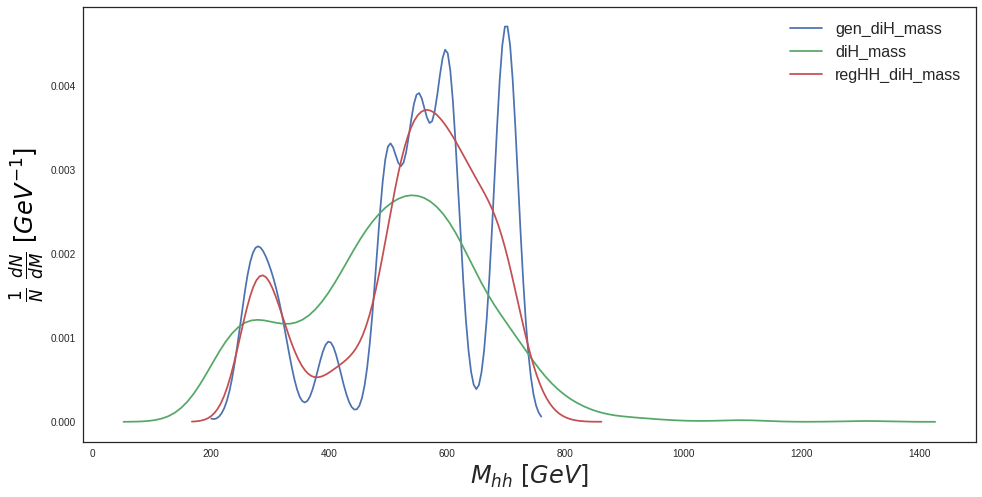

In [94]:
plt.figure(figsize=(16, 8))

sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'])

sns.kdeplot(data=valData.loc[sig, 'diH_mass'])

sns.kdeplot(data=valData.ix[sig, 'regHH_diH_mass'])
plt.legend(fontsize=16)
plt.xlabel(r"$M_{hh}\ [GeV]$", fontsize=24)
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dM}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [95]:
xPlot = np.linspace(0, 1500, 1500)[:, np.newaxis]
plots = mpRun([{'data':valData.loc[bkg, 'diH_mass'], 'x':xPlot, 'name':'bkg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[bkg, 'regHH_diH_mass'], 'x':xPlot, 'name':'bkg_reg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'diH_mass'], 'x':xPlot, 'name':'sig', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'regHH_diH_mass'], 'x':xPlot, 'name':'sig_reg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'gen_diH_mass'], 'x':xPlot, 'name':'gen', 'kde':1, 'mean':1, 'std':1}])

In [96]:
meanReco = (np.mean(plots['sig' + '_mean']),
            np.std(plots['sig' + '_mean'])/math.sqrt(len(plots['sig' + '_mean'])))
stdReco = (np.mean(plots['sig' + '_std']),
             np.std(plots['sig' + '_std'])/math.sqrt(len(plots['sig' + '_std'])))
meanReg = (np.mean(plots['sig_reg' + '_mean']),
            np.std(plots['sig_reg' + '_mean'])/math.sqrt(len(plots['sig_reg' + '_mean'])))
stdReg = (np.mean(plots['sig_reg' + '_std']),
             np.std(plots['sig_reg' + '_std'])/math.sqrt(len(plots['sig_reg' + '_std'])))
meanGen = (np.mean(plots['gen' + '_mean']),
            np.std(plots['gen' + '_mean'])/math.sqrt(len(plots['gen' + '_mean'])))
stdGen = (np.mean(plots['gen' + '_std']),
             np.std(plots['gen' + '_std'])/math.sqrt(len(plots['gen' + '_std'])))

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


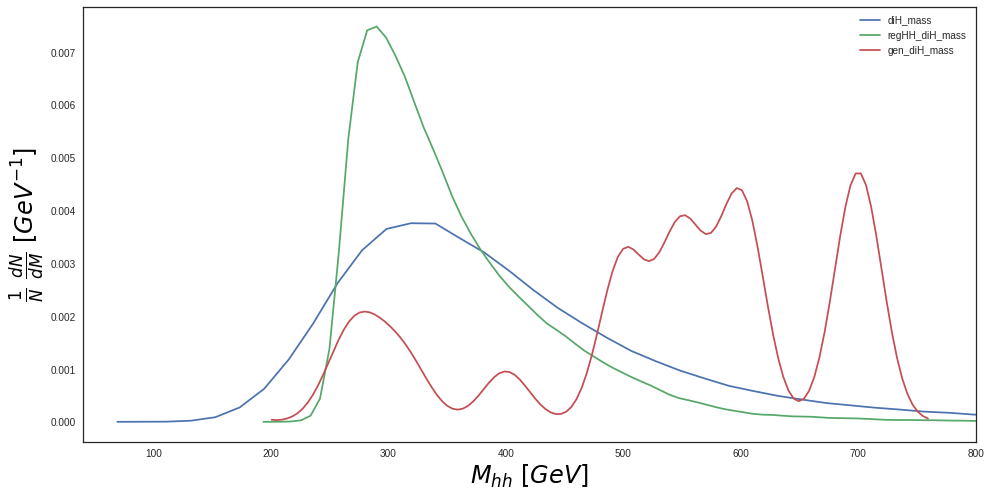

In [115]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData.loc[bkg, 'diH_mass'])
sns.kdeplot(data=valData[bkg]['regHH_diH_mass'])
#sns.kdeplot(data=valData.loc[sig, 'diH_mass'])
#sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'])
plt.xlim(40,800)
plt.xlabel(r"$M_{hh}\ [GeV]$", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dM}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()


In [98]:
pullRegHH = valData[sig]['regHH_diH_mass'].values-valData[sig]['gen_diH_mass'].values
pullReco = valData[sig]['diH_mass'].values-valData[sig]['gen_diH_mass'].values
xPlot = np.linspace(-300, 300, 600)[:, np.newaxis]
bootReco = []
meanBootReco = []
stdevBootReco = []
for i in range(100):
    points = np.random.choice(pullReco, len(pullReco), replace=True)
    meanBootReco.append(points.mean())
    stdevBootReco.append(points.std())
meanReco = (np.mean(meanBootReco), np.std(meanBootReco)/math.sqrt(len(meanBootReco)))
stdevReco = (np.mean(stdevBootReco), np.std(stdevBootReco)/math.sqrt(len(stdevBootReco)))
bootRegHH = []
meanBootRegHH = []
stdevBootRegHH = []
for i in range(100):
    points = np.random.choice(pullRegHH, len(pullRegHH), replace=True)
    meanBootRegHH.append(points.mean())
    stdevBootRegHH.append(points.std())
meanRegHH = (np.mean(meanBootRegHH), np.std(meanBootRegHH)/math.sqrt(len(meanBootRegHH)))
stdevRegHH = (np.mean(stdevBootRegHH), np.std(stdevBootRegHH)/math.sqrt(len(stdevBootRegHH)))
print ('Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegHH[0], meanRegHH[1], stdevRegHH[0], stdevRegHH[1]))
print ('Reconstructed Signal,  Mean = {} +- {}, sigma = {} +- {}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))

Regressed Signal, Mean = -1.79316837364 +- 0.120342292851, sigma = 38.1409922654 +- 0.124004735728
Reconstructed Signal,  Mean = -35.1090234923 +- 0.321520915891, sigma = 88.2616980568 +- 0.539861272282


In [99]:
xPlot = np.linspace(-300, 300, 600)[:, np.newaxis]
plots = mpRun([{'data':valData.loc[sig, 'diH_mass']-valData.ix[sig,'gen_diH_mass'], 'x':xPlot, 'name':'reco', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'regHH_diH_mass']-valData.ix[sig,'gen_diH_mass'], 'x':xPlot, 'name':'reg', 'kde':1, 'mean':1, 'std':1}])

/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]


In [100]:
meanReco = (np.mean(plots['reco' + '_mean']),
            np.std(plots['reco' + '_mean'])/math.sqrt(len(plots['reco' + '_mean'])))
stdReco = (np.mean(plots['reco' + '_std']),
             np.std(plots['reco' + '_std'])/math.sqrt(len(plots['reco' + '_std'])))
meanReg = (np.mean(plots['reg' + '_mean']),
            np.std(plots['reg' + '_mean'])/math.sqrt(len(plots['reg' + '_mean'])))
stdReg = (np.mean(plots['reg' + '_std']),
             np.std(plots['reg' + '_std'])/math.sqrt(len(plots['reg' + '_std'])))

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


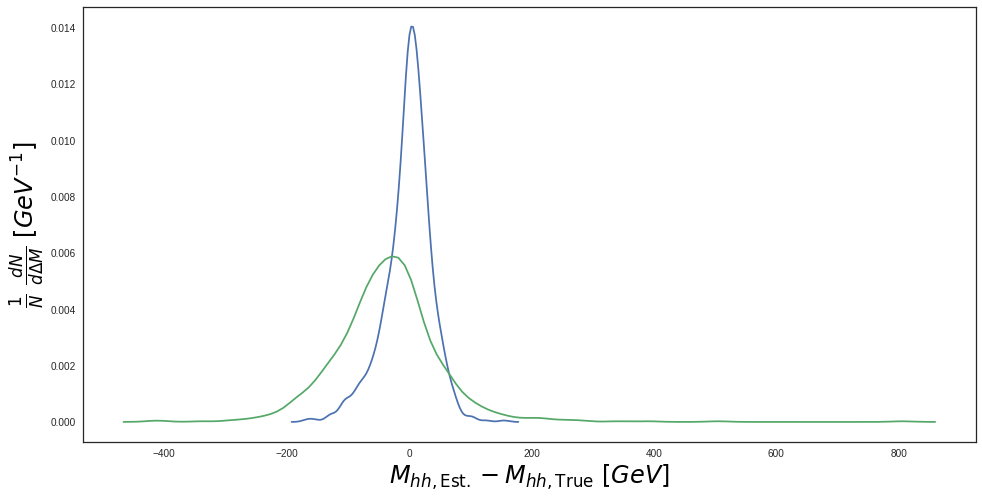

In [101]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=pullRegHH)
sns.kdeplot(data=pullReco)
plt.xlabel(r"$M_{hh,\mathrm{Est.}}-M_{hh,\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.yticks
plt.show()

### ROC Curve

In [102]:
print ('Reg:', roc_auc_score(valData.ix[sig|bkg, 'gen_target'], valData.ix[sig|bkg, 'regHH_diH_mass']))
print ('Reco:', roc_auc_score(valData.ix[sig|bkg, 'gen_target'], valData.ix[sig|bkg, 'diH_mass']))

Reg: 0.842502851368
Reco: 0.708101966221


/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


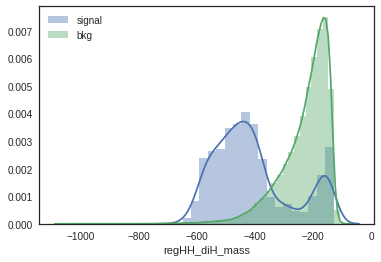

In [103]:
sns.distplot(-np.abs(125-valData.ix[sig, 'regHH_diH_mass']), label='signal')
sns.distplot(-np.abs(125-valData.ix[bkg, 'regHH_diH_mass']), label='bkg')
plt.legend()

## Classifiers response

### Train

In [104]:
classFeatures = ['b_0_mass',
                 'b_1_mass',
                 't_0_mass',
                 't_1_mass',
                 'mPT_px', 'mPT_py',
                 'diH_px', 'diH_py', 'diH_pz', 'diH_E', 'diH_|p|',
                 'hl_mT']

In [105]:
recoFeatures = ['diH_mass']
recoFeatures += ['b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E',
                 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E',
                 't_0_px', 't_0_py', 't_0_pz', 't_0_E', 't_0_|p|',
                 't_1_px', 't_1_py', 't_1_pz', 't_1_E', 't_1_|p|',
                 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E',
                 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_mass', 'h_tt_E', 'h_tt_|p|']
recoFeatures += classFeatures
print (len(recoFeatures), "Training features")
recoClass = xgb.XGBClassifier(base_score=0.5, learning_rate=0.3,
         gamma=0, max_depth=6, missing=-999.0, n_estimators=100, random_state=0,n_jobs=8)
recoClass.fit(valData[recoFeatures], valData['gen_target'].values.astype('int'))

44 Training features


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=-999.0, n_estimators=100,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [106]:
regFeatures = ['regHH_diH_mass']
regFeatures += ['regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_0_|p|', 'regB_b_0_E',
                'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_1_|p|', 'regB_b_1_E',
                'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_0_E', 'regTau_t_0_|p|',
                'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_1_E', 'regTau_t_1_|p|',
                'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regTau_h_tt_mass', 'regTau_h_tt_E', 'regTau_h_tt_|p|',
                'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regB_h_bb_|p|', 'regB_h_bb_E']
regFeatures += classFeatures
regClass = xgb.XGBClassifier(base_score=0.5, learning_rate=0.3,
         gamma=0, max_depth=6, missing=-999.0, n_estimators=100, random_state=0,n_jobs=8)
regClass.fit(valData[regFeatures], valData['gen_target'].values.astype('int'))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=-999.0, n_estimators=100,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Test

In [107]:
recoPred = recoClass.predict_proba(valData[recoFeatures])[:,1]

In [108]:
regPred = regClass.predict_proba(valData[regFeatures])[:,1]

In [109]:
recoAUC = roc_auc_score(valData['gen_target'].values, recoPred)
regAUC = roc_auc_score(valData['gen_target'].values, regPred)

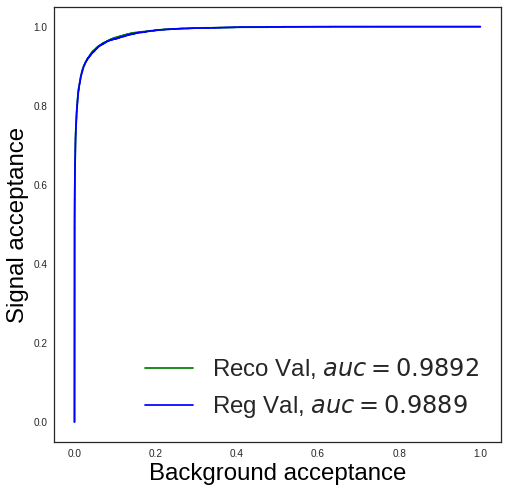

In [110]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(valData['gen_target'].values, recoPred)[:2],
         label=r'Reco Val, $auc={:.4f}$'.format(recoAUC), color='g')
plt.plot(*roc_curve(valData['gen_target'].values, regPred)[:2],
         label=r'Reg Val, $auc={:.4f}$'.format(regAUC), color='b')
#plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=24)
plt.show()

## Save/load

In [111]:
name = "weights/NN_HH_Regressor_App_" + mode + "_" 
print (name)

weights/NN_HH_Regressor_App_mu_tau_b_b_


### Save

In [112]:
os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for i, model in enumerate(ensemble):
    json_string = model.to_json()
    open(name + '_' + str(i) + '.json', 'w').write(json_string)
    model.save_weights(name + '_' + str(i) + '.h5')
with open(name + '_compile.json', 'w') as fout:
    json.dump(compileArgs, fout)
with open(name + '_weights.pkl', 'w') as fout:
    pickle.dump(weights, fout)
with open(name + '_inputPipe.pkl', 'w') as fout:
    pickle.dump(inputPipe, fout)
with open(name + '_outputPipe.pkl', 'w') as fout:
    pickle.dump(outputPipe, fout)

### Load

In [113]:
ensemble = []
weights = None
inputPipe = None
outputPipe = None
compileArgs = None
with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    ensemble.append(model)
with open(name + '_weights.pkl', 'r') as fin:
    weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'r') as fin:
    outputPipe = pickle.load(fin)